In [37]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
sns.reset_orig()
sns.set_style('white')
mpl.rcParams['pdf.fonttype'] = 42

### Define feature sets

In [3]:
prot_feat_arr = ['Degree','Betweenness','Closeness','Eigenvector',
                 'ClusteringCoeff','Load', 'Pagerank']
print('# Protein-level features (Prot): %s' % len(prot_feat_arr))

res_feat_arr = ['3DLoc_Annot', 'Percent_Degree_Change',
                'Degree_Change','Betweenness_Change','Closeness_Change','Eigenvector_Change',
                'ClusteringCoeff_Change','Load_Change', 'Pagerank_Change']
print('# Residue-level features (Res): %s' % len(res_feat_arr))

net_feat_arr = ['3DLoc_Annot',
                'Degree','Betweenness','Closeness','Eigenvector',
                'ClusteringCoeff','Load', 'Pagerank',
                'Percent_Degree_Change',
                'Degree_Change','Betweenness_Change','Closeness_Change','Eigenvector_Change',
                'ClusteringCoeff_Change','Load_Change', 'Pagerank_Change']
print('# Network-based features (Net=Prot+Res): %s' % len(net_feat_arr))

aa_feat_arr = ['AABLOSUM', 'AACharge', 'AACOSMIC', 'AACOSMICvsHapMap', 'AACOSMICvsSWISSPROT', 'AAEx', 
               'AAGrantham', 'AAHapMap', 'AAHGMD2003', 'AAHydrophobicity', 'AAMJ', 'AAPAM250', 'AAPolarity', 
               'AATransition', 'AATripletFirstDiffProb', 'AATripletFirstProbMut', 'AATripletFirstProbWild', 
               'AATripletSecondDiffProb', 'AATripletSecondProbMut', 'AATripletSecondProbWild', 
               'AATripletThirdDiffProb', 'AATripletThirdProbMut', 'AATripletThirdProbWild', 'AAVB', 'AAVolume', 
               'ExonConservation', 'ExonHapMapSnpDensity', 'ExonSnpDensity', 'HMMEntropy', 'HMMPHC', 
               'HMMRelEntropy', 'MGAEntropy', 'MGAPHC', 'MGARelEntropy', 'PredBFactorF', 'PredBFactorM', 
               'PredBFactorS', 'PredRSAB', 'PredRSAE', 'PredRSAI', 'PredSSC', 'PredSSE', 'PredSSH', 
               'PredStabilityH', 'PredStabilityL', 'PredStabilityM', 'RegCompC', 'RegCompDE', 'RegCompEntropy', 
               'RegCompG', 'RegCompH', 'RegCompILVM', 'RegCompKR', 'RegCompNormEntropy', 'RegCompP', 'RegCompQ', 
               'RegCompWYF', 'UniprotACTSITE', 'UniprotBINDING', 'UniprotCABIND', 'UniprotCARBOHYD', 
               'UniprotCOMPBIAS', 'UniprotDISULFID', 'UniprotDNABIND', 'UniprotDOM_Chrom', 'UniprotDOM_LOC', 
               'UniprotDOM_MMBRBD', 'UniprotDOM_PostModEnz', 'UniprotDOM_PostModRec', 'UniprotDOM_PPI', 
               'UniprotDOM_RNABD', 'UniprotDOM_TF', 'UniprotLIPID', 'UniprotMETAL', 'UniprotMODRES', 
               'UniprotMOTIF', 'UniprotNPBIND', 'UniprotPROPEP', 'UniprotREGIONS', 'UniprotREP', 'UniprotSECYS', 
               'UniprotSIGNAL', 'UniprotSITE', 'UniprotTRANSMEM', 'UniprotZNFINGER']
# Remove these 2 features from aa_feat_arr because they had NaN values for all mutations
aa_feat_arr.remove('UniprotLIPID')
aa_feat_arr.remove('UniprotSECYS')
print('# Classic amino acid features (AA): %s' % len(aa_feat_arr))

tot_feat_arr = net_feat_arr + aa_feat_arr
print('# All features (Net+AA): %s' % len(tot_feat_arr))

# Protein-level features (Prot): 7
# Residue-level features (Res): 9
# Network-based features (Net=Prot+Res): 16
# Classic amino acid features (AA): 83
# All features (Net+AA): 99


In [4]:
# Define positive and negative mutation classes
pos, neg = 'Driver', 'Passenger'

### Read training set for cancer using ExtNet
#### 1:4 ratio of Driver vs. Passenger mutations
#### All feature values are normalized

In [5]:
# read normalized features
total_df_norm = pd.read_table('../data/ExtNet_cancer_features_1-4_norm.txt')
print(total_df_norm.shape)
print('# driver mutations: %s' % len(total_df_norm[total_df_norm['Mut_type']==pos]))
print('# passenger mutations: %s' % len(total_df_norm[total_df_norm['Mut_type']==neg]))
print('# all mutations: %s' % len(total_df_norm))
total_df_norm.head()

(8062, 106)
# driver mutations: 1513
# passenger mutations: 6549
# all mutations: 8062


,Index,Mut_type,UID,Unip,Accession,Res,AA_Change,3DLoc_Annot,Degree,Betweenness,...,UniprotMODRES,UniprotMOTIF,UniprotNPBIND,UniprotPROPEP,UniprotREGIONS,UniprotREP,UniprotSIGNAL,UniprotSITE,UniprotTRANSMEM,UniprotZNFINGER
0,0,Driver,1,O00255,ENST00000337652,362,D362H,-0.784087,0.074034,-0.182668,...,-0.064085,-0.057398,-0.063888,-0.08974,2.891795,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404
1,1,Driver,2,O00255,ENST00000337652,184,E184K,1.466936,0.074034,-0.182668,...,-0.064085,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404
2,2,Driver,3,O00255,ENST00000337652,160,S160F,0.341424,0.074034,-0.182668,...,-0.064085,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404
3,3,Driver,6,O14497,ENST00000324856,2143,R2143C,1.466936,0.025723,-0.221841,...,-0.064085,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404
4,4,Driver,7,O14497,ENST00000324856,665,G665A,-0.784087,0.025723,-0.221841,...,-0.064085,-0.057398,-0.063888,-0.08974,-0.345803,-0.234045,-0.061958,-0.023957,-0.183294,-0.115404


#### Use all mutations to train a classifier

In [8]:
# Set training set features X
X = total_df_norm[tot_feat_arr].values
print(X.shape)
# Set training set target values y
y = [1 if mut==pos else 0 for mut in total_df_norm['Mut_type'].values]
print(len(y))

(8062, 99)
8062


#### Train RF classifier

In [9]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, max_features='sqrt', random_state=0, n_jobs=-1)

# Train the classifier using the training set (X, y)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Random Forest feature importances (MDI)

In [15]:
# Look at gini importance of each feature
gini_dict = dict()
for (feat, val) in zip(tot_feat_arr, clf.feature_importances_):
    gini_dict[feat]=val

In [33]:
feat_imp_df = pd.DataFrame.from_dict(gini_dict, orient='index', columns=['Score'])
feat_imp_df['Features'] = feat_imp_df.index
feat_imp_df = feat_imp_df[['Features','Score']].copy()
feat_imp_df = feat_imp_df.sort_values(ascending=False, by='Score')
feat_imp_df = feat_imp_df.set_index(np.arange(1,len(feat_imp_df)+1))
feat_imp_df.head(20)

,Features,Score
1,Load,0.080891
2,Betweenness,0.075151
3,Pagerank,0.065258
4,Degree,0.056216
5,Closeness,0.053667
6,ClusteringCoeff,0.041437
7,Eigenvector,0.040102
8,Load_Change,0.030014
9,Betweenness_Change,0.027134
10,AATripletThirdProbWild,0.021521


In [34]:
feat_imp_df.to_csv('../out/feature_importance.csv')

### Figure S2

In [44]:
mpl.rc('figure', titlesize=10)
mpl.rc('xtick', labelsize=7)
mpl.rc('ytick', labelsize=7)
mpl.rc('legend', fontsize=6)
mpl.rc('axes', labelsize=8)

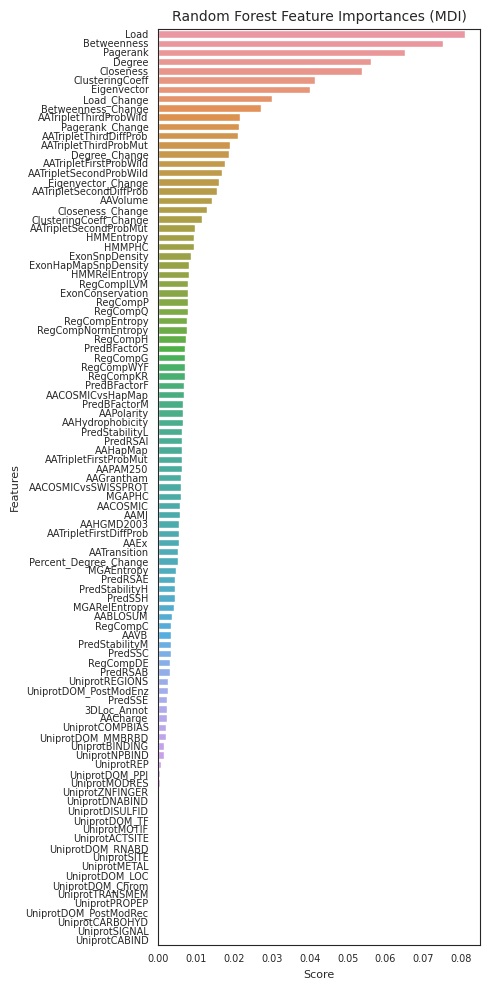

In [45]:
plt.figure(figsize=(5,10))
fig = sns.barplot(y="Features", x="Score", data=feat_imp_df)
fig.set_title("Random Forest Feature Importances (MDI)", fontsize=10)
plt.savefig('../out/figures/FigS2.pdf', transparent=True, dpi=300)
plt.tight_layout()